In [8]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp
import numpy as np
from jax import config
config.update("jax_enable_x64", True)

from data import generate_data, generate_observation_matrix
from loss import create_loss
from network import init_net, compute_end_to_end, compute_factor, compress_network
from solver import train
from utils import compose, svd

In [2]:
key = PRNGKey(0)

# Simulated Data
r = 5
d = 1000

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

key, subkey = split(key)
percent_observed = 0.20
mask = generate_observation_matrix(key=subkey, percent_observed=percent_observed, shape=(d, d))

train_loss_fn = create_loss(target, mask=mask)
test_loss_fn = create_loss(target, mask=1-mask)
loss_fn_dict = {
    'train': train_loss_fn,
    'test': test_loss_fn
}
network_fn = compute_end_to_end

tol = 1e-10
n_outer_loops = 2000
n_trials = 5

input_dim = d
output_dim = d
init_scale = 1e-3
depth = 3
step_size = 5e3

rhats = jnp.arange(5, 21, 3)

2024-01-28 21:06:47.524109: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
narrow_test_loss_mean = []
narrow_test_loss_std = []
narrow_num_iters_mean = []
narrow_num_iters_std = []
narrow_times_mean = []
narrow_times_std = []

for rhat in rhats:
    print(f'{rhat=}')
    
    test_losses = []
    num_iters = []
    times = []
    
    for _ in range(n_trials):
        key, subkey = split(key)
        init_weights = init_net(
            key=subkey, 
            input_dim=input_dim, 
            output_dim=output_dim, 
            width=2*rhat, 
            depth=depth, 
            init_scale=init_scale
        )

        result = train(
            init_weights=init_weights,
            network_fn=network_fn,
            loss_fn_dict=loss_fn_dict,
            n_outer_loops=n_outer_loops,
            step_size=step_size,
            tol=tol
        )
        
        test_losses.append(result['test_loss'][-1])
        num_iters.append(len(result['test_loss']))
        times.append(result['time'][-1])
        
    test_losses = jnp.array(test_losses)
    num_iters = jnp.array(num_iters)
    times = jnp.array(times)
        
    narrow_test_loss_mean.append(jnp.mean(test_losses))
    narrow_test_loss_std.append(jnp.std(test_losses))
    narrow_num_iters_mean.append(jnp.mean(num_iters))
    narrow_num_iters_std.append(jnp.std(num_iters))
    narrow_times_mean.append(jnp.mean(times))
    narrow_times_std.append(jnp.std(times))

rhat=Array(5, dtype=int64)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

rhat=Array(8, dtype=int64)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

rhat=Array(11, dtype=int64)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

rhat=Array(14, dtype=int64)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

rhat=Array(17, dtype=int64)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

rhat=Array(20, dtype=int64)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [4]:
comp_test_loss_mean = []
comp_test_loss_std = []
comp_num_iters_mean = []
comp_num_iters_std = []
comp_times_mean = []
comp_times_std = []

for rhat in rhats:
    print(f'{rhat=}')
    test_losses = []
    num_iters = []
    times = []
    
    for _ in range(n_trials):
        key, subkey = split(key)
        
        init_weights = init_net(
            key=subkey, 
            input_dim=input_dim, 
            output_dim=output_dim, 
            width=output_dim, 
            depth=depth, 
            init_scale=init_scale
        )
        
        V = compute_factor(init_weights=init_weights, network_fn=network_fn, loss_fn=train_loss_fn, grad_rank=rhat)
        comp_init_weights = compress_network(init_weights=init_weights, V=V, grad_rank=rhat)
        
        dlr = 0.01

        result = train(
            init_weights=comp_init_weights,
            network_fn=network_fn,
            loss_fn_dict=loss_fn_dict,
            n_outer_loops=n_outer_loops,
            step_size=step_size,
            dlr=dlr,
            tol=tol,
            save_weights=True
        )
        
        test_losses.append(result['test_loss'][-1])
        num_iters.append(len(result['test_loss']))
        times.append(result['time'][-1])
        
    test_losses = jnp.array(test_losses)
    num_iters = jnp.array(num_iters)
    times = jnp.array(times)
        
    comp_test_loss_mean.append(jnp.mean(test_losses))
    comp_test_loss_std.append(jnp.std(test_losses))
    comp_num_iters_mean.append(jnp.mean(num_iters))
    comp_num_iters_std.append(jnp.std(num_iters))
    comp_times_mean.append(jnp.mean(times))
    comp_times_std.append(jnp.std(times))

rhat=Array(5, dtype=int64)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

rhat=Array(8, dtype=int64)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

rhat=Array(11, dtype=int64)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

rhat=Array(14, dtype=int64)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

rhat=Array(17, dtype=int64)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

rhat=Array(20, dtype=int64)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
narrow_num_iters_mean = np.array(narrow_num_iters_mean)
narrow_num_iters_std = np.array(narrow_num_iters_std)
narrow_times_mean = np.array(narrow_times_mean)
narrow_times_std = np.array(narrow_times_std)

comp_num_iters_mean = np.array(comp_num_iters_mean)
comp_num_iters_std = np.array(comp_num_iters_std)
comp_times_mean = np.array(comp_times_mean)
comp_times_std = np.array(comp_times_std)

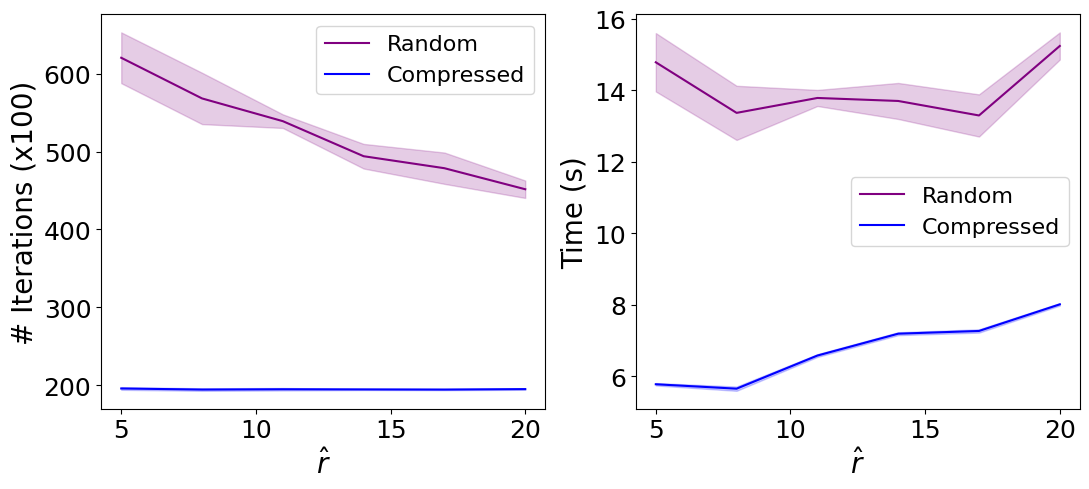

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 5))

axes[0].plot(rhats, narrow_num_iters_mean, c="purple", label="Random")
axes[0].fill_between(rhats, narrow_num_iters_mean - narrow_num_iters_std, narrow_num_iters_mean + narrow_num_iters_std, color="purple", alpha=0.2)
axes[0].plot(rhats, comp_num_iters_mean, c="blue", label="Compressed")
axes[0].fill_between(rhats, comp_num_iters_mean - comp_num_iters_std, comp_num_iters_mean + comp_num_iters_std, color="blue", alpha=0.2)
# axes[0].errorbar(rhats, narrow_num_iters_mean, yerr=narrow_num_iters_std, fmt='-o', c='blue', capsize=5, markersize=8, linewidth=4, label='Narrow, Width=$2\hat{r}$')
# axes[0].errorbar(rhats, comp_num_iters_mean, yerr=comp_num_iters_std, fmt='-o', c='green', capsize=5, markersize=8, linewidth=4, label='Compressed')
axes[0].set_xlabel(r'$\hat{r}$', fontsize=20)
axes[0].set_ylabel('# Iterations (x100)', fontsize=20)
# axes[0].vlines(x=5, ymin=200, ymax=1000, colors='r', linestyles='--', label='True Rank')
axes[0].legend(fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=18)

axes[1].plot(rhats, narrow_times_mean, c="purple", label="Random")
axes[1].fill_between(rhats, narrow_times_mean - narrow_times_std, narrow_times_mean + narrow_times_std, color="purple", alpha=0.2)
axes[1].plot(rhats, comp_times_mean, c="blue", label="Compressed")
axes[1].fill_between(rhats, comp_times_mean - comp_times_std, comp_times_mean + comp_times_std, color="blue", alpha=0.2)
# axes[1].errorbar(rhats, narrow_times_mean, yerr=narrow_times_std, fmt='-o', c='blue', capsize=5, markersize=8, linewidth=4, label='Narrow, Width=$2\hat{r}$')
# axes[1].errorbar(rhats, comp_times_mean, yerr=comp_times_std, fmt='-o', c='green', capsize=5, markersize=8, linewidth=4, label='Compressed')
axes[1].set_xlabel(r'$\hat{r}$', fontsize=20)
axes[1].set_ylabel('Time (s)', fontsize=20)
# axes[1].vlines(x=5, ymin=4, ymax=20, colors='r', linestyles='--', label='True Rank')
axes[1].legend(fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=18)
fig.tight_layout()

plt.savefig('figs/comp_iter_time.png', dpi=500, bbox_inches='tight')